In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [3]:
batch_size = 32
img_h = 180
img_w = 180
epochs = 10

In [4]:
train_df = tf.keras.utils.image_dataset_from_directory(
    "data",
    validation_split = 0.2,
    subset= 'training',
    seed= 123,
    image_size = (img_h, img_w),
    batch_size = batch_size
)

Found 4188 files belonging to 4 classes.
Using 3351 files for training.


In [5]:
valid_df = tf.keras.utils.image_dataset_from_directory(
    "data",
    validation_split = 0.2,
    subset = "validation",
    seed=123,
    image_size = (img_h,img_w),
    batch_size = batch_size
)

Found 4188 files belonging to 4 classes.
Using 837 files for validation.


In [34]:
import os 
path= 'C:/Users/Dell/Documents/python projects/ecofarm/data'

class_names = sorted(os.listdir(path))

num_class = len(class_names)

print('class_names: \n', class_names)

class_sizes = []

for name in class_names:
    class_size = len(os.listdir(path + '/' + name))
    class_sizes.append(class_size)
    
print('class distr: \n', class_sizes)

class_names: 
 ['Blight', 'Common_Rust', 'Gray_Leaf_Spot', 'Healthy']
class distr: 
 [1146, 1306, 574, 1162]


In [58]:
data_aug =  tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.5),
    layers.RandomZoom(0.3),
    layers.RandomContrast(0.1),
    layers.RandomBrightness(0.1)
])

In [63]:
num_cl = len(train_df.class_names)
def model_prop(d=128,l=2e-3):
    from tensorflow.keras.applications import MobileNetV2
    from tensorflow.keras.regularizers import l2

    base_model = MobileNetV2(weights='imagenet',input_shape=(img_h,img_w,3),include_top=False)

    base_model.trainable= False
    
    model = Sequential(
        [ 
            data_aug,
            base_model,
            layers.GlobalAveragePooling2D(),
            layers.Dense(d,activation='relu'),
            # layers.BatchNormalization(),
            layers.Dropout(0.2),
            
            layers.Dense(num_cl,activation='softmax')
        ]
    )
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.002),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics= ['accuracy'])

    
    return model,base_model

In [ ]:
model,base_model = model_prop()

model.summary()

C:\Users\Dell\AppData\Local\Temp\ipykernel_6444\3216102987.py:6: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet',input_shape=(img_h,img_w,3),include_top=False)


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_6 (Sequential)       │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 6, 6, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_5      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,430,980 (9.27 MB)

 Trainable params: 172,740 (674.77 KB)

 Non-trainable params: 2,258,240 (8.61 MB)

In [10]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

early = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)
lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2)



In [29]:
his = model.fit(train_df, validation_data=valid_df, epochs=20, callbacks=[early, lr_reduce])

Epoch 1/20


105/105 ━━━━━━━━━━━━━━━━━━━━ 153s 1s/step - accuracy: 0.7389 - loss: 0.6719 - val_accuracy: 0.8076 - val_loss: 0.4337 - learning_rate: 0.0020
Epoch 2/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 101s 958ms/step - accuracy: 0.7905 - loss: 0.5074 - val_accuracy: 0.8148 - val_loss: 0.4063 - learning_rate: 0.0020
Epoch 3/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 113s 1s/step - accuracy: 0.8135 - loss: 0.4494 - val_accuracy: 0.8112 - val_loss: 0.4043 - learning_rate: 4.0000e-04
Epoch 4/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 114s 1s/step - accuracy: 0.8174 - loss: 0.4395 - val_accuracy: 0.8148 - val_loss: 0.4105 - learning_rate: 4.0000e-04


In [37]:
model.save('plantv2.keras')

In [38]:
his1 = model.fit(train_df, validation_data=valid_df, epochs=20, callbacks=[early, lr_reduce])

Epoch 1/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 160s 1s/step - accuracy: 0.3041 - loss: 5.1765 - val_accuracy: 0.4648 - val_loss: 4.3350 - learning_rate: 2.0000e-05
Epoch 2/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 109s 1s/step - accuracy: 0.3891 - loss: 4.7844 - val_accuracy: 0.5556 - val_loss: 4.1350 - learning_rate: 2.0000e-05
Epoch 3/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 105s 1s/step - accuracy: 0.4050 - loss: 4.6909 - val_accuracy: 0.5830 - val_loss: 4.0973 - learning_rate: 4.0000e-06
Epoch 4/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 105s 997ms/step - accuracy: 0.4214 - loss: 4.6144 - val_accuracy: 0.5938 - val_loss: 4.0668 - learning_rate: 4.0000e-06


In [40]:
his3 = model.fit(train_df, validation_data=valid_df, epochs=20, callbacks=[early, lr_reduce])

Epoch 1/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 117s 1s/step - accuracy: 0.3351 - loss: 4.9743 - val_accuracy: 0.4456 - val_loss: 4.3435 - learning_rate: 8.0000e-07
Epoch 2/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 156s 1s/step - accuracy: 0.3330 - loss: 4.9512 - val_accuracy: 0.4134 - val_loss: 4.3604 - learning_rate: 8.0000e-07
Epoch 3/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 129s 1s/step - accuracy: 0.3471 - loss: 4.9705 - val_accuracy: 0.4038 - val_loss: 4.3847 - learning_rate: 1.6000e-07
Epoch 4/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 157s 1s/step - accuracy: 0.3521 - loss: 4.9468 - val_accuracy: 0.3978 - val_loss: 4.4013 - learning_rate: 1.6000e-07


In [57]:
his4 = model.fit(train_df, validation_data=valid_df, epochs=20, callbacks=[early, lr_reduce])

Epoch 1/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 109s 1s/step - accuracy: 0.3462 - loss: 4.9406 - val_accuracy: 0.4062 - val_loss: 4.3737 - learning_rate: 3.2000e-08
Epoch 2/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 174s 2s/step - accuracy: 0.3414 - loss: 4.9431 - val_accuracy: 0.3907 - val_loss: 4.4013 - learning_rate: 3.2000e-08
Epoch 3/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 168s 1s/step - accuracy: 0.3453 - loss: 4.9229 - val_accuracy: 0.3895 - val_loss: 4.4184 - learning_rate: 6.4000e-09
Epoch 4/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 134s 1s/step - accuracy: 0.3450 - loss: 5.0027 - val_accuracy: 0.3859 - val_loss: 4.4406 - learning_rate: 6.4000e-09


In [60]:
his5 = model.fit(train_df, validation_data=valid_df, epochs=20, callbacks=[early, lr_reduce])

Epoch 1/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 127s 1s/step - accuracy: 0.3375 - loss: 4.9829 - val_accuracy: 0.3907 - val_loss: 4.4005 - learning_rate: 1.2800e-09
Epoch 2/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 132s 1s/step - accuracy: 0.3474 - loss: 4.9436 - val_accuracy: 0.3847 - val_loss: 4.4280 - learning_rate: 1.2800e-09
Epoch 3/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 171s 2s/step - accuracy: 0.3321 - loss: 5.0040 - val_accuracy: 0.3871 - val_loss: 4.4411 - learning_rate: 2.5600e-10
Epoch 4/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 234s 2s/step - accuracy: 0.3548 - loss: 4.9284 - val_accuracy: 0.3907 - val_loss: 4.4506 - learning_rate: 2.5600e-10


In [64]:
his6 = model.fit(train_df, validation_data=valid_df, epochs=20, callbacks=[early, lr_reduce])

Epoch 1/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 122s 1s/step - accuracy: 0.3378 - loss: 4.9422 - val_accuracy: 0.3859 - val_loss: 4.4465 - learning_rate: 2.0480e-12
Epoch 2/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 121s 1s/step - accuracy: 0.3372 - loss: 4.9702 - val_accuracy: 0.3871 - val_loss: 4.4627 - learning_rate: 2.0480e-12
Epoch 3/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 136s 1s/step - accuracy: 0.3318 - loss: 5.0304 - val_accuracy: 0.3895 - val_loss: 4.4689 - learning_rate: 4.0960e-13
Epoch 4/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 110s 1s/step - accuracy: 0.3390 - loss: 4.9733 - val_accuracy: 0.3871 - val_loss: 4.4681 - learning_rate: 4.0960e-13


In [49]:
his.history

{'accuracy': [0.738883912563324,
  0.7905102968215942,
  0.8134884834289551,
  0.8173679709434509],
 'loss': [0.6718552112579346,
  0.5073744654655457,
  0.44937455654144287,
  0.43946948647499084],
 'val_accuracy': [0.8076463341712952,
  0.8148148059844971,
  0.8112305998802185,
  0.8148148059844971],
 'val_loss': [0.43366867303848267,
  0.40625691413879395,
  0.4043404757976532,
  0.4105460047721863],
 'learning_rate': [0.0020000000949949026,
  0.0020000000949949026,
  0.0004000000189989805,
  0.0004000000189989805]}

In [50]:
his.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss', 'learning_rate'])

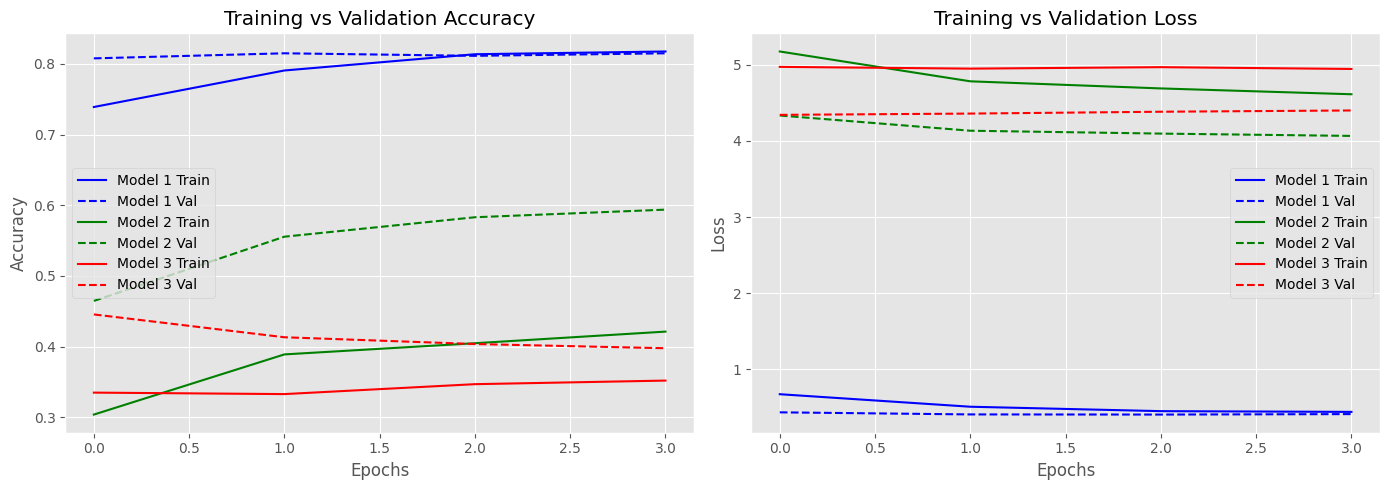

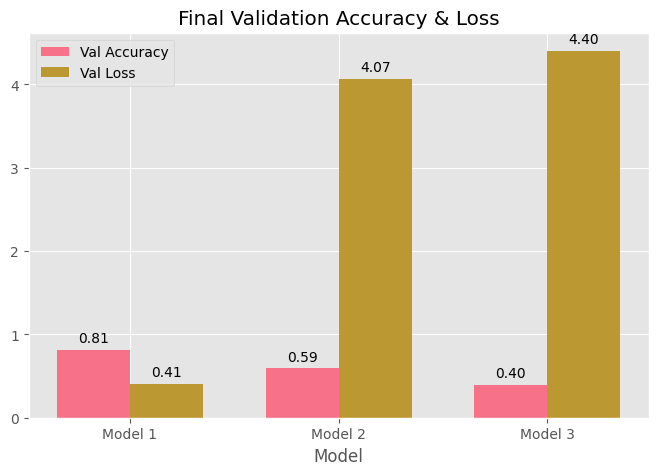

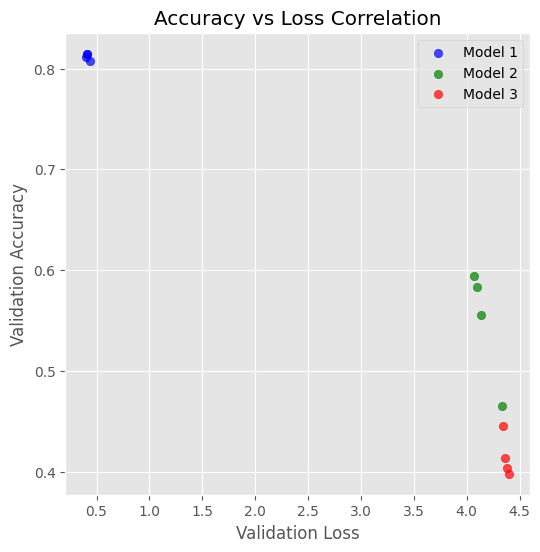

In [52]:
import matplotlib.pyplot as plt

# Assuming his, his1, his2 are your model histories
histories = [his, his1, his3]
labels = ['Model 1', 'Model 2', 'Model 3']
colors = ['blue', 'green', 'red']

# --- 1️⃣ Line Charts for Accuracy and Loss ---
fig, axs = plt.subplots(1, 2, figsize=(14, 5))

for h, label, color in zip(histories, labels, colors):
    axs[0].plot(h.history['accuracy'], label=f'{label} Train', linestyle='-',
                color=color)
    axs[0].plot(h.history['val_accuracy'], label=f'{label} Val', linestyle='--',
                color=color)
axs[0].set_title('Training vs Validation Accuracy')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Accuracy')
axs[0].legend()

for h, label, color in zip(histories, labels, colors):
    axs[1].plot(h.history['loss'], label=f'{label} Train', linestyle='-',
                color=color)
    axs[1].plot(h.history['val_loss'], label=f'{label} Val', linestyle='--',
                color=color)
axs[1].set_title('Training vs Validation Loss')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Loss')
axs[1].legend()

plt.tight_layout()
plt.show()

# --- 2️⃣ Bar Chart for Final Performance ---
import numpy as np

final_acc = [h.history['val_accuracy'][-1] for h in histories]
final_loss = [h.history['val_loss'][-1] for h in histories]

x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots(figsize=(8,5))
bars1 = ax.bar(x - width/2, final_acc, width, label='Val Accuracy')
bars2 = ax.bar(x + width/2, final_loss, width, label='Val Loss')

ax.set_xlabel('Model')
ax.set_title('Final Validation Accuracy & Loss')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

for bar in bars1 + bars2:
    height = bar.get_height()
    ax.annotate(f'{height:.2f}', xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3), textcoords="offset points",
                ha='center', va='bottom')

plt.show()

# --- 3️⃣ Scatter Plot (Accuracy vs Loss Correlation) ---
fig, ax = plt.subplots(figsize=(6,6))
for h, label, color in zip(histories, labels, colors):
    ax.scatter(h.history['val_loss'], h.history['val_accuracy'],
               label=label, color=color, alpha=0.7)
ax.set_xlabel('Validation Loss')
ax.set_ylabel('Validation Accuracy')
ax.set_title('Accuracy vs Loss Correlation')
ax.legend()
plt.show()


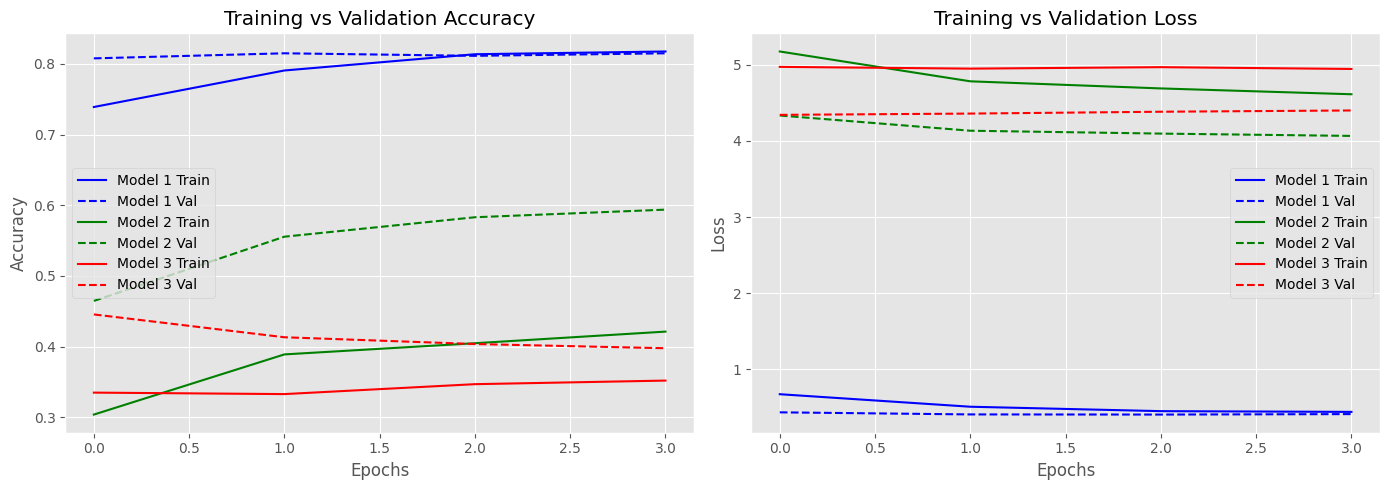

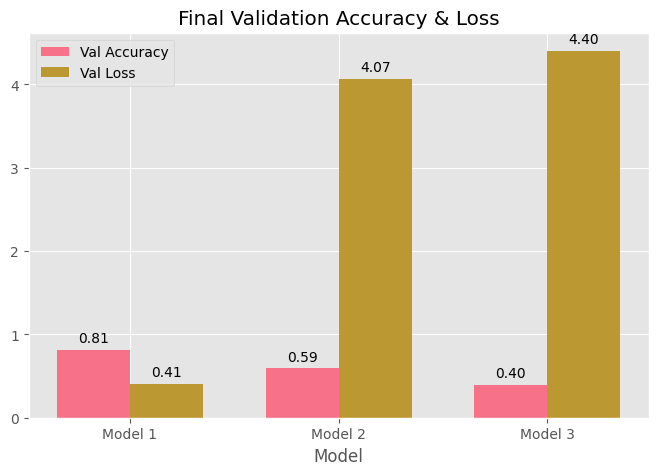

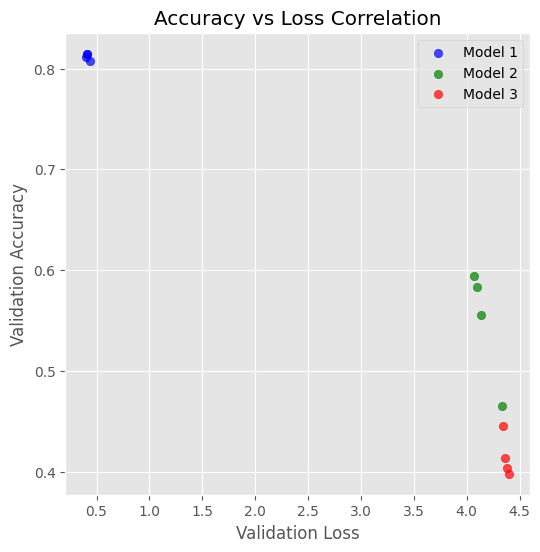

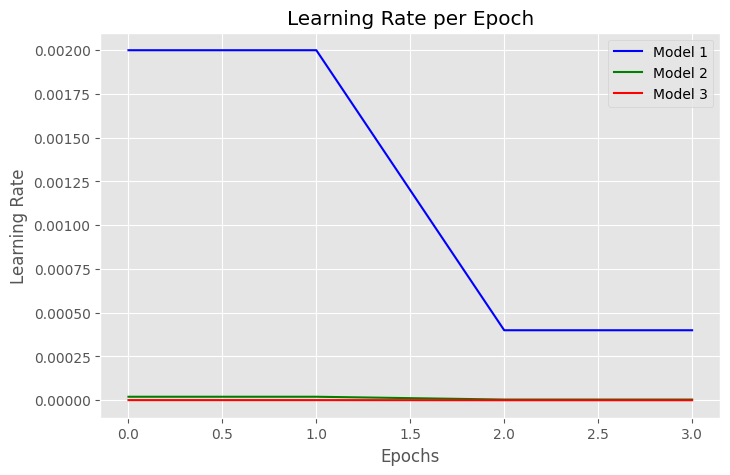

In [54]:
import matplotlib.pyplot as plt
import numpy as np

# --- Setup ---
histories = [his, his1, his3]
labels = ['Model 1', 'Model 2', 'Model 3']
colors = ['blue', 'green', 'red']

# --- 1️⃣ Accuracy & Loss Line Charts ---
fig, axs = plt.subplots(1, 2, figsize=(14, 5))

# Accuracy plot
for h, label, color in zip(histories, labels, colors):
    axs[0].plot(h.history['accuracy'], label=f'{label} Train', linestyle='-',
                color=color)
    axs[0].plot(h.history['val_accuracy'], label=f'{label} Val', linestyle='--',
                color=color)
axs[0].set_title('Training vs Validation Accuracy')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Accuracy')
axs[0].legend()

# Loss plot
for h, label, color in zip(histories, labels, colors):
    axs[1].plot(h.history['loss'], label=f'{label} Train', linestyle='-',
                color=color)
    axs[1].plot(h.history['val_loss'], label=f'{label} Val', linestyle='--',
                color=color)
axs[1].set_title('Training vs Validation Loss')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Loss')
axs[1].legend()

plt.tight_layout()
plt.show()

# --- 2️⃣ Bar Chart for Final Validation Metrics ---
final_acc = [h.history['val_accuracy'][-1] for h in histories]
final_loss = [h.history['val_loss'][-1] for h in histories]

x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots(figsize=(8, 5))
bars1 = ax.bar(x - width/2, final_acc, width, label='Val Accuracy')
bars2 = ax.bar(x + width/2, final_loss, width, label='Val Loss')

ax.set_xlabel('Model')
ax.set_title('Final Validation Accuracy & Loss')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

for bar in bars1 + bars2:
    height = bar.get_height()
    ax.annotate(f'{height:.2f}', xy=(bar.get_x() + bar.get_width()/2, height),
                xytext=(0, 3), textcoords="offset points",
                ha='center', va='bottom')

plt.show()

# --- 3️⃣ Scatter Plot (Accuracy vs Loss Correlation) ---
fig, ax = plt.subplots(figsize=(6, 6))
for h, label, color in zip(histories, labels, colors):
    ax.scatter(h.history['val_loss'], h.history['val_accuracy'],
               label=label, color=color, alpha=0.7)
ax.set_xlabel('Validation Loss')
ax.set_ylabel('Validation Accuracy')
ax.set_title('Accuracy vs Loss Correlation')
ax.legend()
plt.show()

# --- 4️⃣ Learning Rate Trend ---
fig, ax = plt.subplots(figsize=(8, 5))
for h, label, color in zip(histories, labels, colors):
    ax.plot(h.history['learning_rate'], label=label, color=color)
ax.set_title('Learning Rate per Epoch')
ax.set_xlabel('Epochs')
ax.set_ylabel('Learning Rate')
ax.legend()
plt.show()


In [55]:
# --- 5️⃣ Summary Comparison & Highlight Best Model ---
final_val_acc = [h.history['val_accuracy'][-1] for h in histories]
final_val_loss = [h.history['val_loss'][-1] for h in histories]
final_lr = [h.history['learning_rate'][-1] for h in histories]

best_idx = int(np.argmax(final_val_acc))
best_model = labels[best_idx]

print("=== Model Comparison Summary ===")
for i, label in enumerate(labels):
    print(f"{label}:")
    print(f"  Final Validation Accuracy: {final_val_acc[i]:.4f}")
    print(f"  Final Validation Loss:     {final_val_loss[i]:.4f}")
    print(f"  Final Learning Rate:       {final_lr[i]:.6f}")
    print("")

print(f"🏆 Best Performing Model: {best_model}")
print(f"Improvement Margin: {((final_val_acc[best_idx] - min(final_val_acc)) / min(final_val_acc)) * 100:.2f}% over weakest model.")


=== Model Comparison Summary ===
Model 1:
  Final Validation Accuracy: 0.8148
  Final Validation Loss:     0.4105
  Final Learning Rate:       0.000400

Model 2:
  Final Validation Accuracy: 0.5938
  Final Validation Loss:     4.0668
  Final Learning Rate:       0.000004

Model 3:
  Final Validation Accuracy: 0.3978
  Final Validation Loss:     4.4013
  Final Learning Rate:       0.000000

🏆 Best Performing Model: Model 1
Improvement Margin: 104.80% over weakest model.


In [65]:
base_model.trainable = True

# Freeze most layers — only keep last 50 trainable
for layer in base_model.layers[:-50]:
    layer.trainable = False


model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.002),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

history2 = model.fit(train_df, validation_data=valid_df, epochs=20, callbacks=[early, lr_reduce])



Epoch 1/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 184s 1s/step - accuracy: 0.7243 - loss: 2.5506 - val_accuracy: 0.7945 - val_loss: 1.5416 - learning_rate: 0.0020
Epoch 2/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 170s 2s/step - accuracy: 0.7804 - loss: 1.3434 - val_accuracy: 0.8100 - val_loss: 1.0162 - learning_rate: 0.0020
Epoch 3/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 165s 2s/step - accuracy: 0.8007 - loss: 1.0096 - val_accuracy: 0.8172 - val_loss: 0.8975 - learning_rate: 4.0000e-04
Epoch 4/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 173s 2s/step - accuracy: 0.8045 - loss: 0.9189 - val_accuracy: 0.8184 - val_loss: 0.8358 - learning_rate: 4.0000e-04


In [ ]:
model.save('plantv3.keras')

In [66]:
base_model.trainable = True

# Freeze most layers — only keep last 50 trainable
for layer in base_model.layers[:110]:
    layer.trainable = False


model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=2e-6),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy'])

history3 = model.fit(train_df, validation_data=valid_df, epochs=20, callbacks=[early, lr_reduce])

Epoch 1/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 168s 1s/step - accuracy: 0.7750 - loss: 1.6573 - val_accuracy: 0.8184 - val_loss: 1.5065 - learning_rate: 2.0000e-06
Epoch 2/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 129s 1s/step - accuracy: 0.7634 - loss: 1.6682 - val_accuracy: 0.8172 - val_loss: 1.5024 - learning_rate: 2.0000e-06
Epoch 3/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 130s 1s/step - accuracy: 0.7696 - loss: 1.6621 - val_accuracy: 0.8148 - val_loss: 1.5024 - learning_rate: 4.0000e-07
Epoch 4/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 132s 1s/step - accuracy: 0.7792 - loss: 1.6487 - val_accuracy: 0.8136 - val_loss: 1.5025 - learning_rate: 4.0000e-07


In [68]:
model.save('plantv3.keras')

In [ ]:
from tensorflow.keras.preprocessing import image
import numpy as np

class_names = train_df.class_names

def prep_img(imf_path,img_h,img_w):
  img= image.load_img(img_path,target_size=(img_h,img_w))
  img_arr = image.img_to_array(img)
  img_arr = np.expand_dims(img_arr,axis=0)
  return img_arr
# C:\Users\Dell\Documents\python projects\deep tech\boat data\train\20130412_122808_99204.jpg
# C:\Users\Dell\Documents\python projects\deep tech\boat data\train\20130412_122352_97982.jpg
img_path = "boat data/train/VaporettoACTV2.jpeg"
img_arr = prep_img(img_path,img_h,img_w)
prediction = model.predict(img_arr)
# prediction
pred_class_idx = np.argmax(prediction, axis=1)[0]
pred_class_name = class_names[pred_class_idx]
pred_class_name
